In [1]:
from data.dataset import MFData
from run_lib import run_hogp_2d
from infras.misc import cprint, create_path, get_logger
import os
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm.auto import tqdm, trange
import tensorly as tl


class KernelARD:
    def __init__(self, jitter):
        self.jitter = jitter

    def matrix(self, X, ls):
        K = self.cross(X, X, ls)
        Ijit = self.jitter * torch.eye(X.shape[0]).to(K.device)
        K = K + Ijit
        return K

    def cross(self, X1, X2, ls):
        ls_sqrt = torch.sqrt(ls)
        X1 = X1 / ls_sqrt
        X2 = X2 / ls_sqrt
        norm1 = torch.reshape(torch.sum(torch.square(X1), dim=1), [-1, 1])
        norm2 = torch.reshape(torch.sum(torch.square(X2), dim=1), [1, -1])
        K = norm1 - 2.0 * torch.matmul(X1, X2.T) + norm2
        # K = amp*torch.exp(-1.0*K)
        K = torch.exp(-1.0 * K)
        return K



class Net(nn.Module):
    def __init__(self, layers, act=nn.Tanh()):
        super(Net, self).__init__()
        self.act = act
        self.fc = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.fc.append(nn.Linear(layers[i], layers[i + 1]))

    def forward(self, x):
        for i in range(len(self.fc) - 1):
            x = self.fc[i](x)
            x = self.act(x)
        x = self.fc[-1](x)
        return x

class HoGPR:
    # X: training data, N x s
    # Y: training output tensor, N x d_1 x ... x d_K
    # R: dimension of latent features per output mode
    # device: cpu or gpu
    def __init__(self, X, Y, R, device, jitter=1e-3):
        self.device = device
        self.X = torch.tensor(X, device=self.device, requires_grad=False)
        self.Y = torch.tensor(Y, device=self.device, requires_grad=False)
        self.N = X.shape[0]
        self.nout_mode = self.Y.ndim - 1
        self.jitter = jitter
        # features per mode
        # self.V = [self.X]
        # cprint('r', X.shape)
        self.u_net = Net([X.shape[1], 8, X.shape[1] + 1]).to(self.device)
        self.X_trans = self.u_net(self.X)
        self.V = [self.X_trans]
        # latent features per output mode
        for m in range(self.nout_mode):
            self.V.append(torch.randn(self.Y.shape[m + 1], R, device=self.device, requires_grad=True))
            # nn.init.xavier_normal_(self.V[-1])
            # self.V.append(torch.rand(self.Y.shape[m+1], R, device=self.device, requires_grad=True))
        self.log_ls = [torch.tensor(np.zeros(self.V[m].shape[1]), device=self.device, requires_grad=True) for m in
                       range(len(self.V))]
        self.kernel = [KernelARD(self.jitter) for m in range(len(self.V))]
        self.log_tau = torch.tensor(0.0, device=self.device, requires_grad=True)
        # hack an awkard property
        self.Y_mean = None
        self.Y_std = None

    def neg_ll_surrogate(self):
        noise_var = torch.exp(-self.log_tau)
        self.V[0] = self.u_net(self.X)
        # kernel matrices
        Kmat = [self.kernel[m].matrix(self.V[m], torch.exp(self.log_ls[m])) for m in range(len(self.V))]
        Eigenvals = [torch.linalg.eigvalsh(Kmat[m]).reshape([-1, 1]) for m in range(len(self.V))]
        A = tl.cp_tensor.cp_to_tensor((torch.ones(1).to(self.device), Eigenvals)) + noise_var
        log_detK = torch.sum(torch.log(A))
        with torch.no_grad():
            U = []
            Ut = []
            for m in range(len(self.V)):
                damb, eigvecs = torch.linalg.eigh(Kmat[m])
                U.append(eigvecs.real)
                Ut.append(eigvecs.real.T)
            A1 = tl.tenalg.multi_mode_dot(self.Y, Ut)
            A1 = A1 / A
            G = tl.tenalg.multi_mode_dot(A1, U)
        A2 = tl.tenalg.multi_mode_dot(G, Kmat) + noise_var * G
        neg_ll_surr = 0.5 * log_detK - 0.5 * torch.sum(A2 * G)
        return neg_ll_surr

    def pred(self, Xte):
        with torch.no_grad():
            # cross_klist = [self.kernel[0].cross(Xte, self.X, torch.exp(self.log_ls[0]))]
            cross_klist = [self.kernel[0].cross(self.u_net(Xte), self.u_net(self.X), torch.exp(self.log_ls[0]))]
            Kmat = [self.kernel[m].matrix(self.V[m], torch.exp(self.log_ls[m])) for m in range(len(self.V))]
            U = []
            Ut = []
            Lam = []
            for m in range(self.nout_mode):
                cross_klist.append(Kmat[m + 1])
            for m in range(len(self.V)):
                eigvals, eigvecs = torch.linalg.eigh(Kmat[m])
                U.append(eigvecs.real)
                Ut.append(eigvecs.real.T)
                Lam.append(eigvals.real.reshape([-1, 1]))

            noise_var = torch.exp(-self.log_tau)
            A = tl.cp_tensor.cp_to_tensor((torch.ones(1).to(self.device), Lam)) + noise_var
            A1 = tl.tenalg.multi_mode_dot(self.Y, Ut)
            A1 = A1 / A
            G = tl.tenalg.multi_mode_dot(A1, U)
            pred_mean = tl.tenalg.multi_mode_dot(G, cross_klist)
            return pred_mean

    # using Matheron's rule to gnerate M independent posterior sample; X_star can be multiple inputs
    def posterior_samples(self, X_star, M):
        X_aug = torch.cat((self.X, X_star), dim=0)
        # cprint('r', X_aug.shape)
        X_aug = self.u_net(X_aug)
        K0 = self.kernel[0].matrix(X_aug, torch.exp(self.log_ls[0]))
        Kmat = [self.kernel[m].matrix(self.V[m], torch.exp(self.log_ls[m])) for m in range(1, len(self.V))]
        Kmat = [K0] + Kmat
        # generate prior samples first
        Chols = [torch.linalg.cholesky(Kmat[m]) for m in range(len(self.V))]
        nvec = [Kmat[m].shape[0] for m in range(len(self.V))]  # (N + N*) x d1 x ... x dK
        Noise = torch.normal(0.0, 1.0, size=[M] + nvec).to(self.device)  # M x (N+N*) x d1 x ... x dK
        # M x (N+N*) x d1 x ... x dK
        F = tl.tenalg.multi_mode_dot(Noise, Chols, modes=[j for j in range(1, len(self.V) + 1)])
        # M x N x d1 x ... x dK
        nvec[0] = self.N
        noise_std = torch.exp(-0.5 * self.log_tau)
        F1 = F[:, 0:self.N] + noise_std * torch.normal(0.0, 1.0, size=[M] + nvec).to(self.device)
        F2 = F[:, self.N:]  # M x N* x d1 x ... x dK
        Ydiff = self.Y - F1  # M x N x d1 x ... x dK
        # we do not need the following for gradient tracking
        with torch.no_grad():
            Kmat[0] = K0[0:self.N, 0:self.N]
            U = []
            Ut = []
            Lam = []
            for m in range(len(self.V)):
                eigvals, eigvecs = torch.linalg.eigh(Kmat[m])
                U.append(eigvecs.real)
                Ut.append(eigvecs.real.T)
                Lam.append(eigvals.real.reshape([-1, 1]))
            noise_var = torch.exp(-self.log_tau)
            A = tl.cp_tensor.cp_to_tensor((torch.ones(1).to(self.device), Lam)) + noise_var  # N x d1 x ... x dK
            A1 = tl.tenalg.multi_mode_dot(Ydiff, Ut, modes=[j for j in range(1, len(self.V) + 1)])
            A1 = A1 / A  # M x N x d1 x ... x dK
            G = tl.tenalg.multi_mode_dot(A1, U, modes=[j for j in range(1, len(self.V) + 1)])
        Kmat[0] = K0[self.N:, 0:self.N]
        post_samples = tl.tenalg.multi_mode_dot(G, Kmat, modes=[j for j in range(1, len(self.V) + 1)]) + F2
        return post_samples  # M x N* x d1 x .... x dK

    def train(self, Xte, Yte, lr, weight_decay, scheduler, min_lr, max_epochs, test_freq, logger=None, save_path=None):

        Xte = torch.tensor(Xte, device=self.device)
        Yte = torch.tensor(Yte, device=self.device)
        paras = self.V[1:] + self.log_ls + [self.log_tau] + [p for p in self.u_net.parameters()]

        minimizer = Adam(paras, lr=lr, weight_decay=weight_decay)
        if scheduler == 'CosAnnealingLR':
            cprint('y', 'INFO: Cosine annealing scheduler applied.')
            iterations = max_epochs
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(minimizer, T_max=iterations)
        elif scheduler == 'ReduceLROnPlateau':
            cprint('y', 'INFO: Reduce on plateau scheduler applied.')
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(minimizer, 'min', min_lr=min_lr)
        elif scheduler == 'NA':
            scheduler = None
            cprint('y', 'INFO: no scheduler applied.')
            cprint('y', 'training with no scheduler used...')

        hist_nrmse_tr = []
        hist_nrmse_te = []

        best_rmse = np.inf

        for epoch in tqdm(range(max_epochs + 1)):
            minimizer.zero_grad()
            loss = self.neg_ll_surrogate()
            loss.backward(retain_graph=True)
            minimizer.step()

            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                _, nrmse_te, _, _, _ = self._callback(Xte, Yte)
                scheduler.step(nrmse_te)
            elif isinstance(scheduler, torch.optim.lr_scheduler.CosineAnnealingLR):
                scheduler.step()

            if epoch % test_freq == 0:
                nrmse_tr, nrmse_te, nmae_tr, nmae_te, tau = self._callback(Xte, Yte)

                if nrmse_te < best_rmse:
                    best_rmse = nrmse_te
                    self.save_state(save_path)

                info_str = '\nepoch={}, nelbo={:.5f}, best_rmse={:.5f}, tau={:.5f}\n'.format(epoch, loss.item(), best_rmse, tau)
                info_str += '  - nrmse_tr={}\n'.format(nrmse_tr)
                info_str += '  - nrmse_te={}\n'.format(nrmse_te)
                info_str += '  - nmae_tr={}\n'.format(nmae_tr)
                info_str += '  - nmae_te={}\n'.format(nmae_te)

                hist_nrmse_tr.append(nrmse_tr)
                hist_nrmse_te.append(nrmse_te)

                if tau > (1 / 1e-5):
                    break
            #
        #

        return np.array(hist_nrmse_tr), np.array(hist_nrmse_te)

        # self._callback(Xte, Yte, max_epochs)

    def _callback(self, Xte, Yte):
        with torch.no_grad():
            pred_tr = self.pred(self.X)
            pred_te = self.pred(Xte)

            nrmse_tr = torch.sqrt(torch.mean(torch.square(pred_tr - self.Y))) / torch.sqrt(torch.square(self.Y).mean())
            nrmse_te = torch.sqrt(torch.mean(torch.square(pred_te - Yte))) / torch.sqrt(torch.square(Yte).mean())

            nmae_tr = torch.mean(torch.abs(pred_tr - self.Y)) / torch.abs(self.Y).mean()
            nmae_te = torch.mean(torch.abs(pred_te - Yte)) / torch.abs(Yte).mean()

            return nrmse_tr.item(), nrmse_te.item(), nmae_tr.item(), nmae_te.item(), torch.exp(self.log_tau).item()

    def save_state(self, path):

        hgpr_state = {}

        log_tau_state = self.log_tau.detach().data
        # print(log_tau_state)

        Vstates = []
        for v_state in self.V:
            # print(v_state.detach().data.cpu())
            Vstates.append(v_state.detach().data)
        #

        log_ls_states = []
        for log_ls_state in self.log_ls:
            # print(log_ls_state.detach().data.cpu())
            log_ls_states.append(log_ls_state.detach().data)
        #

        # print(self.u_net.cpu().state_dict())

        hgpr_state['log_tau_state'] = log_tau_state
        hgpr_state['Vstates'] = Vstates
        hgpr_state['log_ls_states'] = log_ls_states
        hgpr_state['u_net_state'] = self.u_net.state_dict()


    def load_state(self, path):

        with open(os.path.join(path, 'model.pt'), 'rb') as handle:
            hgpr_state = pickle.load(handle)

        self.log_tau.data = hgpr_state['log_tau_state']

        for idx, (v, v_state) in enumerate(zip(self.V, hgpr_state['Vstates'])):
            assert v.shape == v_state.shape
            v.data = v_state

        for idx, (ls, ls_state) in enumerate(zip(self.log_ls, hgpr_state['log_ls_states'])):
            #print(idx, ls.shape, ls_state.shape)
            ls.data = ls_state

        self.u_net.load_state_dict(hgpr_state['u_net_state'])




def run_hogp_2d(
        config,
        dataset,
):

    Xtr, ytr, ttr = dataset.get_unifid_data_stack(
        selectd_fids=dataset.fid_list_tr,
        train=True,
        scale=config.data.normalize,
    )

    Xte, yte, tte = dataset.get_unifid_data_stack(
        selectd_fids=[dataset.target_fidelity],
        train=False,
        scale=config.data.normalize,
    )

    meshsize = config.data.target_fidelity

    Xtr = Xtr.data.cpu().numpy()
    Xte = Xte.data.cpu().numpy()
    ytr = ytr.data.cpu().numpy().reshape((-1, meshsize, meshsize))
    yte = yte.data.cpu().numpy().reshape((-1, meshsize, meshsize))
    ttr = ttr.data.cpu().numpy()
    tte = tte.data.cpu().numpy()

    Xtrain = np.hstack((Xtr, ttr))
    Xtest = np.hstack((Xte, tte))

    model = HoGPR(Xtrain, ytr, config.model.rank, 'cpu')

    hist_nrmse_tr, hist_nrmse_te = model.train(
        Xtest, yte,
        lr=0.01,
        weight_decay=0.00001,
        scheduler='ReduceLROnPlateau',
        min_lr=0.001,
        max_epochs=5000,
        test_freq=5,
        logger=None,
        save_path=None,
    )
    return hist_nrmse_tr, hist_nrmse_te

class DataFilesConfig:
    def __init__(self, path, fid_list_te, fid_list_tr, generate, interp, n_threas, ns_list_te, ns_list_tr):
        self.path = path
        self.fid_list_te = fid_list_te
        self.fid_list_tr = fid_list_tr
        self.generate = generate
        self.interp = interp
        self.n_threas = n_threas
        self.ns_list_te = ns_list_te
        self.ns_list_tr = ns_list_tr

class ModelConfig:
    def __init__(self, method, rank):
        self.method = method
        self.rank = rank

class TrainingConfig:
    def __init__(self, epochs):
        self.epochs = epochs

class DataConfig:
    def __init__(self, domain, fold, normalize, target_fidelity):
        self.domain = domain
        self.fold = fold
        self.normalize = normalize
        self.target_fidelity = target_fidelity



class Config:
    def __init__(self, model, training, data, datafiles):
        self.model = model
        self.training = training
        self.data = data
        self.datafiles = datafiles

model_config = ModelConfig(method='ifc_ode', rank=5)
training_config = TrainingConfig(epochs=5000)
data_config = DataConfig(domain='heat', fold=1, normalize=True, target_fidelity=64)
datafiles_config = DataFilesConfig(
    path='pde_data',
    fid_list_te=[8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160],
    fid_list_tr=[8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160],
    generate=False,
    interp='linear',
    n_threas=4,
    ns_list_te=[512]*20,
    ns_list_tr=[512]*20
)

config = Config(model=model_config, training=training_config, data=data_config, datafiles=datafiles_config)
# workdir = os.path.join(
#         workdir,
#         config.model.name,
#         'rank{}'.format(config.model.rank),
#         'fold{}'.format(config.data.fold)
#     )
# exp_log_workdir = os.path.join(workdir, 'logs')

# logger = get_logger(os.path.join(exp_log_workdir, 'logging.txt'), displaying=False)

dataset = MFData(
    config,
    domain='Heat',
    fid_min=8,
    fid_max=64,
    t_min=0.0,
    t_max=1.0,
    target_fidelity=64,
    fid_list_tr=[8, 16, 32, 64],
    fid_list_te=[8, 16, 32, 64],
    ns_list_tr=[100, 50, 50, 20],
    ns_list_te=[256, 256, 256, 256],
)
hist_nrmse_tr, hist_nrmse_te = run_hogp_2d(config, dataset)
print(hist_nrmse_te)

Loading saved data threads...
(Train) fid=8, Part1/4 found at pde_data/Heat/train/fidelity_8/part0
(Train) fid=8, Part2/4 found at pde_data/Heat/train/fidelity_8/part1
(Train) fid=8, Part3/4 found at pde_data/Heat/train/fidelity_8/part2
(Train) fid=8, Part4/4 found at pde_data/Heat/train/fidelity_8/part3
(Train) fid=16, Part1/4 found at pde_data/Heat/train/fidelity_16/part0
(Train) fid=16, Part2/4 found at pde_data/Heat/train/fidelity_16/part1
(Train) fid=16, Part3/4 found at pde_data/Heat/train/fidelity_16/part2
(Train) fid=16, Part4/4 found at pde_data/Heat/train/fidelity_16/part3
(Train) fid=24, Part1/4 found at pde_data/Heat/train/fidelity_24/part0
(Train) fid=24, Part2/4 found at pde_data/Heat/train/fidelity_24/part1
(Train) fid=24, Part3/4 found at pde_data/Heat/train/fidelity_24/part2
(Train) fid=24, Part4/4 found at pde_data/Heat/train/fidelity_24/part3
(Train) fid=32, Part1/4 found at pde_data/Heat/train/fidelity_32/part0
(Train) fid=32, Part2/4 found at pde_data/Heat/train/fi

(Test) fid=48, Part3/4 found at pde_data/Heat/test/fidelity_48/part2
(Test) fid=48, Part4/4 found at pde_data/Heat/test/fidelity_48/part3
(Test) fid=56, Part1/4 found at pde_data/Heat/test/fidelity_56/part0
(Test) fid=56, Part2/4 found at pde_data/Heat/test/fidelity_56/part1
(Test) fid=56, Part3/4 found at pde_data/Heat/test/fidelity_56/part2
(Test) fid=56, Part4/4 found at pde_data/Heat/test/fidelity_56/part3
(Test) fid=64, Part1/4 found at pde_data/Heat/test/fidelity_64/part0
(Test) fid=64, Part2/4 found at pde_data/Heat/test/fidelity_64/part1
(Test) fid=64, Part3/4 found at pde_data/Heat/test/fidelity_64/part2
(Test) fid=64, Part4/4 found at pde_data/Heat/test/fidelity_64/part3
(Test) fid=72, Part1/4 found at pde_data/Heat/test/fidelity_72/part0
(Test) fid=72, Part2/4 found at pde_data/Heat/test/fidelity_72/part1
(Test) fid=72, Part3/4 found at pde_data/Heat/test/fidelity_72/part2
(Test) fid=72, Part4/4 found at pde_data/Heat/test/fidelity_72/part3
(Test) fid=80, Part1/4 found at pd

  0%|          | 0/5001 [00:00<?, ?it/s]

[0.65057397 0.32095047 0.30277286 ... 0.04648101 0.04705635 0.04632879]


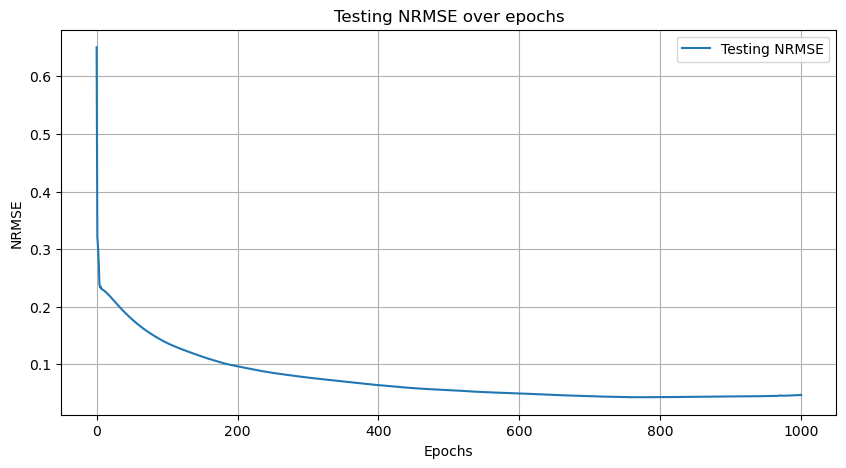

In [2]:
import matplotlib.pyplot as plt

# Assuming hist_nrmse_te is a one-dimensional numpy array containing the testing NRMSE
plt.figure(figsize=(10, 5))
plt.plot(hist_nrmse_te, label='Testing NRMSE')
plt.xlabel('Epochs')
plt.ylabel('NRMSE')
plt.legend()
plt.grid(True)
plt.title('Testing NRMSE over epochs')
plt.show()

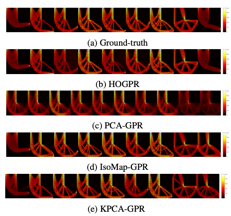

In [1]:
from IPython.display import Image, display
display(Image(filename='__figs__/errors_Topology.png'))